<a href="https://colab.research.google.com/github/G-Gaddu/Quant-Material/blob/main/Fama_French_5_Factor_ipyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
# Import the packages
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# Download the data, in this case we will be looking at Shell over a 20 year period
shell_data = yf.download("SHEL", start="2004-01-01", end="2024-01-01")
shell_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-02,52.750000,53.009998,52.599998,52.750000,18.610559,1879900
2004-01-05,53.529999,53.599998,52.700001,53.529999,18.885752,2421000
2004-01-06,53.849998,54.000000,53.570000,53.849998,18.998650,2858300
2004-01-07,52.650002,52.779999,52.310001,52.650002,18.575274,2963100
2004-01-08,52.759998,52.869999,52.310001,52.759998,18.614084,1860600


<Axes: title={'center': 'Shell Stock Price'}, xlabel='Date'>

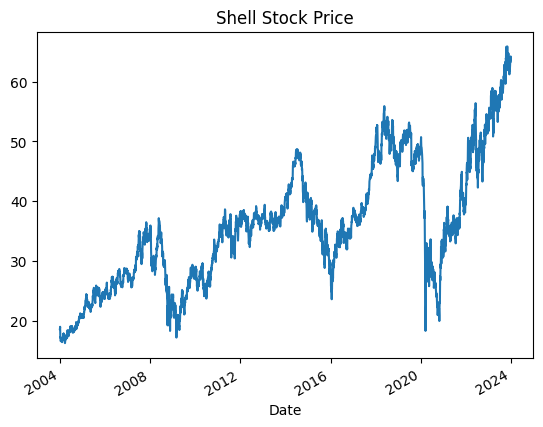

In [3]:
# Plot the Adj Close over the time
shell_data['Adj Close'].plot(title="Shell Stock Price")

In [4]:
# Determine the monthly returns
monthly_data = shell_data['Adj Close'].resample('M').ffill().to_frame()
monthly_data.index = monthly_data.index.to_period('M')
monthly_data['Returns'] = monthly_data['Adj Close'].pct_change()*100
monthly_data.dropna(inplace=True)
monthly_data.head()


,Adj Close,Returns
Date,,
2004-02,17.495691,4.620259
2004-03,16.786549,-4.053242
2004-04,17.605095,4.876204
2004-05,18.122463,2.938742
2004-06,18.694101,3.154307


In [19]:
# Load the Fama French Factors and convert into a dataframe
from google.colab import files
ff5 = files.upload()

Saving F-F_Research_Data_5_Factors_2x3_daily.CSV to F-F_Research_Data_5_Factors_2x3_daily (1).CSV


In [41]:
# Get the ff5 data
ff5_data = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows=3,index_col=0)
ff5_data.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
19630701,-0.67,0.02,-0.35,0.03,0.13,0.012
19630702,0.79,-0.28,0.28,-0.08,-0.21,0.012
19630703,0.63,-0.18,-0.10,0.13,-0.25,0.012
19630705,0.40,0.09,-0.28,0.07,-0.30,0.012
19630708,-0.63,0.07,-0.20,-0.27,0.06,0.012


In [49]:
# Resample the data on a monthly basis and keep the last day of the month
ff5_data = pd.DataFrame(ff5_data)
ff5_data = ff5_data.to_timestamp(freq='M')
ff5_data = ff5_data.resample('M').last()
ff5_data.index = ff5_data.index.to_period('M')
ff5_data

,Mkt-RF,SMB,HML,RMW,CMA,RF
1963-07,-0.13,0.11,-0.03,-0.13,0.30,0.012
1963-08,0.44,0.15,-0.13,0.15,-0.21,0.011
1963-09,-0.60,0.21,0.08,0.24,0.13,0.014
1963-10,0.21,-0.03,0.08,0.10,-0.26,0.013
1963-11,1.34,0.30,0.29,-0.31,-0.15,0.015
...,...,...,...,...,...,...
2024-02,0.54,-0.16,0.97,0.28,-0.73,0.021
2024-03,0.10,0.45,0.49,-0.06,0.09,0.021
2024-04,-1.67,-0.28,-0.26,-0.60,0.63,0.021
2024-05,0.68,-0.03,0.78,0.91,0.80,0.020


In [50]:
# Now ensure that the factor data matches the same time period as the Shell data and determine the excess returns
monthly_data = monthly_data.merge(ff5_data, left_index=True, right_index=True)
monthly_data['Excess_Return'] = monthly_data['Returns'] - monthly_data['RF']
monthly_data.head()

,Adj Close,Returns,Mkt-RF,SMB,HML,RMW,CMA,RF,Excess_Return
2004-02,17.495691,4.620259,0.11,0.29,0.31,0.17,0.28,0.003,4.617259
2004-03,16.786549,-4.053242,0.00,0.22,0.22,0.40,0.02,0.004,-4.057242
2004-04,17.605095,4.876204,-0.66,-0.67,-0.02,1.26,-0.77,0.004,4.872204
2004-05,18.122463,2.938742,0.02,-0.06,0.13,-0.15,0.12,0.003,2.935742
2004-06,18.694101,3.154307,0.48,0.12,0.34,-0.37,0.21,0.004,3.150307


In [52]:
# Run a regression model on the Fama French Factors and the Excess returns
features= sm.add_constant(monthly_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])
model = sm.OLS(monthly_data['Excess_Return'], features)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.038
Date:                Fri, 23 Aug 2024   Prob (F-statistic):              0.396
Time:                        14:52:50   Log-Likelihood:                -792.54
No. Observations:                 239   AIC:                             1597.
Df Residuals:                     233   BIC:                             1618.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7109      0.447      1.591      0.1

<ipython-input-74-a54f0ef8ea51>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, results.params[i], f'p={pval:.3f}', ha='center', va='bottom')


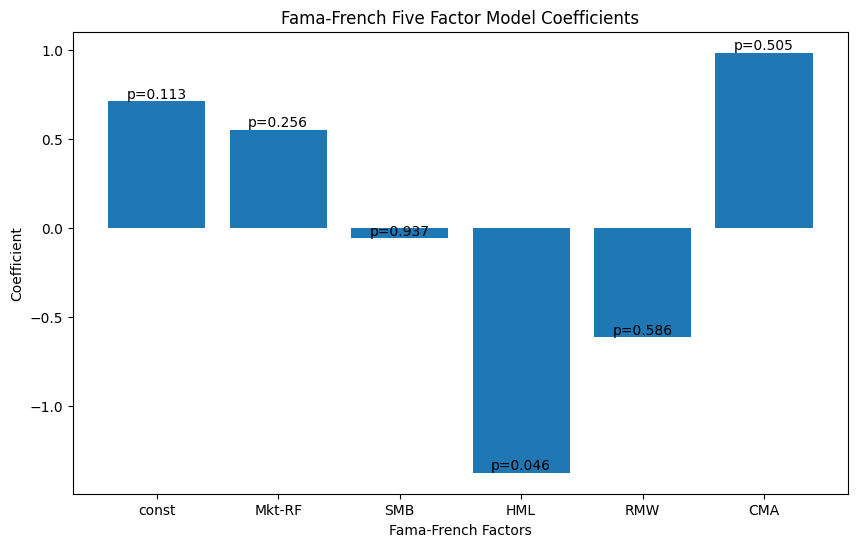

In [74]:
# Plot the coefficient values alongside their P values
plt.figure(figsize=(10, 6))
plt.bar(results.params.index, results.params)
plt.xlabel('Fama-French Factors')
plt.ylabel('Coefficient')
plt.title('Fama-French Five Factor Model Coefficients')

# Add p-values to the chart
for i, pval in enumerate(results.pvalues):
  plt.text(i, results.params[i], f'p={pval:.3f}', ha='center', va='bottom')

plt.show()


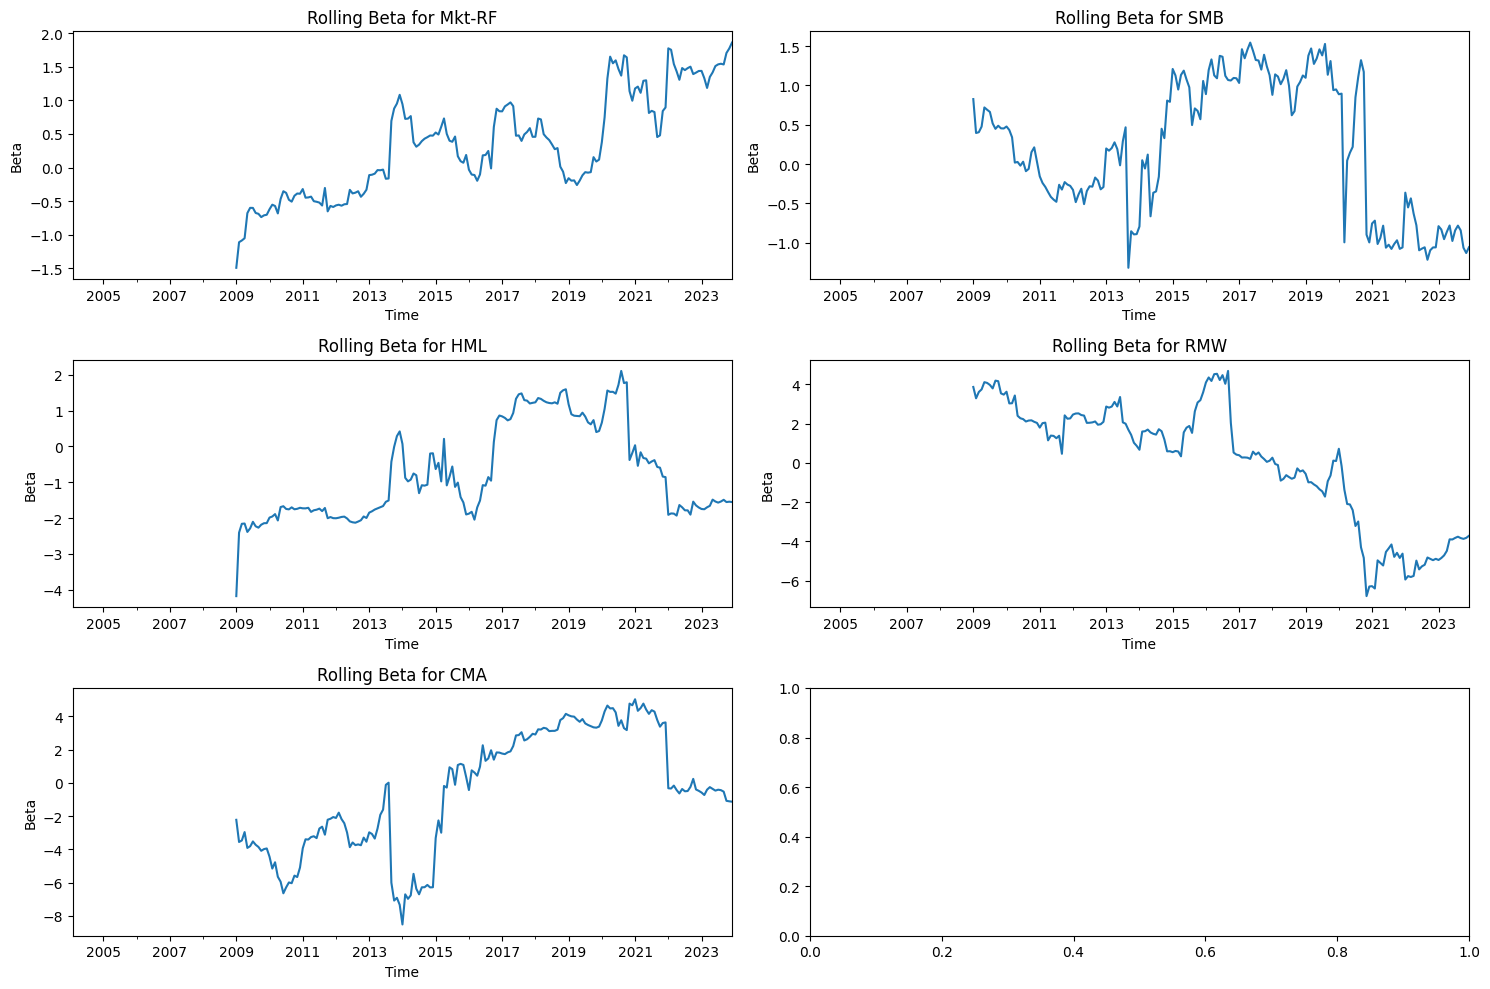

In [75]:
# To determine the stability of the Fama French Factors over time we look at the rolling beta
rolling_betas = monthly_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].rolling(window=60).cov(monthly_data['Excess_Return']) / monthly_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].rolling(window=60).var()

# Plot rolling betas
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes = axes.flatten()

for i, factor in enumerate(['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']):
  rolling_betas[factor].plot(ax=axes[i], title=f"Rolling Beta for {factor}")
  axes[i].set_xlabel("Time")
  axes[i].set_ylabel("Beta")

plt.tight_layout()
plt.show()
